## Dermnet - Kamień milowy 3 (Modelowanie)

### 0. Pakiety

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(2137)
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score, pairwise_distances
from functools import partial
from scipy.spatial import distance
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## 1. Przygotowanie danych
### 1.1. Import

In [2]:
df1 = pd.read_pickle('train_data_1.pkl')
df2 = pd.read_pickle('train_data_2.pkl')
X = pd.concat([df1, df2], axis=0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15557 entries, 0 to 15556
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   15557 non-null  object
dtypes: object(1)
memory usage: 121.7+ KB


Zmiana rozdzielczości z 224x224 px na 75x75 px.

In [3]:
# resize all images
# X_not_resized = X.copy()
X['image'] = X['image'].apply(lambda x: cv2.resize(x, (75, 75)))


### 1.2. Rotacja

In [4]:
# def rotate_all_images(data_frame, colname = 'image'):
#     images_90 = []
#     for image in data_frame[colname]:
#         image_90 = np.rot90(image)
#         images_90.append(image_90)
#     return pd.DataFrame({colname: images_90})


In [5]:
# random.seed(2137)
# # choose 5000 random images
# X_rotated_0 = X.sample(5000)

# X_rotated_90 = rotate_all_images(X_rotated_0)
# X_rotated_180 = rotate_all_images(X_rotated_90)
# X_rotated_270 = rotate_all_images(X_rotated_180)

### 1.3. Modyfikacje obrazów
#### Funkcje

In [29]:
# random.seed(2137)
# chosen_indexes = random.sample(range(len(X['image'])), 8)

# def visualize_random_images(df, indexes = [0, 1, 2, 3, 4, 5, 6, 7]):
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#     for i in range(8):
#         img = df['image'].iloc[indexes[i]]
#         ax = axes[i//4, i%4]
#         ax.imshow(img)
#         ax.axis('off')


# def convert_to_grayscale(data_frame, colname='image'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     result = []
#     k=0
#     for image in data_frame['image']:
#         r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
#         gray = 0.33 * r + 0.33 * g + 0.33 * b
#         result.append(gray)
#     result = pd.DataFrame({colname : result})
#     return result

# def convert_to_grayscale_one_color(data_frame, colname='image'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     result = []
#     k=0
#     for image in data_frame['image']:
#         r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
#         gray = r + g + b
#         result.append(gray)
#     result = pd.DataFrame({colname : result})
#     return result


# def visualize_random_images_grey(df, indexes = [0, 1, 2, 3, 4, 5, 6, 7]):
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#     for i in range(8):
#         img = df['image'].iloc[indexes[i]]
#         ax = axes[i//4, i%4]
#         ax.imshow(img, cmap='gray')
#         ax.axis('off')


# def extract_rgb_channel(data_frame, colname='image', color='red'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     if color == 'red':
#         channel = 0
#     elif color == 'green':
#         channel = 1
#     elif color == 'blue':
#         channel = 2
#     result = []
#     k=0
#     for image in data_frame['image']:
#         modified_image = np.zeros_like(image)
#         modified_image[:,:,channel] = image[:,:,channel]
#         result.append(modified_image)
#     result = pd.DataFrame({colname : result})
#     return result


# def global_threshold(df, tresh, colname = 'image'):
#     '''
#     Runs threshold on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         result.append((image > tresh) * 255)
#     result = pd.DataFrame({colname : result})
#     return result

# def reverse_threshold(df, tresh, colname = 'image'):
#     '''
#     Runs threshold on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         result.append((image < tresh) * 255)
#     result = pd.DataFrame({colname : result})
#     return result

# def detect_images(df, low_th = 50, high_th = 150, blur_ksize = 5, colname = 'image'):
#     '''
#     Runs edge detection on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         image = (image * 255).astype(np.uint8)
#         blurred_image = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

#         edges = cv2.Canny(blurred_image, low_th, high_th)  
#         result.append(edges)
#     result = pd.DataFrame({colname : result})
#     return result

# def convert_to_negative_image(df, colname = 'image'):
#     '''
#     Converts the image to negative
#     '''
#     result = []
#     for image in df[colname]:
#         result.append(255 - image)
#     result = pd.DataFrame({colname : result})
#     return result

# def erosion(df, kernel_size=(5,5), iterations=1, colname='image'):
#     result = []
#     kernel = np.ones(kernel_size, np.uint8)
#     for image in df[colname]:
#         eroded_image = cv2.erode(image, kernel, iterations=iterations)
#         result.append(eroded_image)
#     result = pd.DataFrame({colname: result})
#     return result

# def dilation(df, kernel_size=(5,5), iterations=1, colname='image'):
#     result = []
#     kernel = np.ones(kernel_size, np.uint8)
#     for image in df[colname]:
#         dilated_image = cv2.dilate(image, kernel, iterations=iterations)
#         result.append(dilated_image)
#     result = pd.DataFrame({colname: result})
#     return result

# def reverse_hough_transform(df, threshold=100, colname='image'):
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         image = image.astype(np.uint8)  # Convert to CV_8U data type
#         edges = cv2.Canny(image, 50, 150, apertureSize=3)
#         lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)  # Define 'lines' variable
#         if lines is not None:
#             for rho, theta in lines[:, 0]:
#                 a = np.cos(theta)
#                 b = np.sin(theta)
#                 x0 = a * rho
#                 y0 = b * rho
#                 x1 = int(x0 + 1000 * (-b))
#                 y1 = int(y0 + 1000 * (a))
#                 x2 = int(x0 - 1000 * (-b))
#                 y2 = int(y0 - 1000 * (a))
#                 cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
#         result.append(image)
#     result = pd.DataFrame({colname: result})
#     return result

# def flatten_images(df, colname='image', batch_size=100):
#     num_images = len(df)
#     flattened_data = []
#     for start in range(0, num_images, batch_size):
#         end = min(start + batch_size, num_images)
#         batch_images = df[colname].iloc[start:end]
#         batch_flattened = []
#         for image in batch_images:
#             image_array = img_to_array(image)
#             batch_flattened.append(image_array.flatten() / 255.0)
#         batch_flattened = np.array(batch_flattened)
#         flattened_data.append(batch_flattened)
#     flattened_data = np.concatenate(flattened_data, axis=0)
#     flattened_df = pd.DataFrame(flattened_data, columns=[f'{colname}_{i}' for i in range(flattened_data.shape[1])])
#     return flattened_df


# def modify_pictures(df, colname='image'):

#     # convert and flatten
#     grayscale = convert_to_grayscale(df, colname)
#     grayscale_flatten = flatten_images(grayscale, colname)
#     print('grayscale done')
#     red = extract_rgb_channel(df, colname, 'red')
#     red_flatten = flatten_images(red, colname)
#     print('red done')
#     green = extract_rgb_channel(df, colname, 'green')
#     green_flatten = flatten_images(green, colname)
#     print('green done')
#     blue = extract_rgb_channel(df, colname, 'blue')
#     blue_flatten = flatten_images(blue, colname)
#     print('blue done')
#     thresholded = global_threshold(grayscale, 100, colname)
#     thresholded_flatten = flatten_images(thresholded, colname)
#     print('threshold done') 
#     eroded = erosion(df, colname=colname)
#     eroded_flatten = flatten_images(eroded, colname)
#     print('eroded done')
#     dilated = dilation(df, colname=colname)
#     dilated_flatten = flatten_images(dilated, colname)
#     print('dilated done')
#     hough = reverse_hough_transform(grayscale, colname=colname)
#     hough_flatten = flatten_images(hough, colname)
#     print('hough done')

#     # concatenate
#     result = pd.concat([grayscale_flatten, red_flatten, green_flatten, blue_flatten, thresholded_flatten, eroded_flatten, dilated_flatten, hough_flatten], axis=1)
#     return result


### 1.3.1. Ramka danych `X`
Obrazy z wyciągniętymi kanałami R, G i B niosą w sumie te same informacje, co obraz kolorowy czy negatyw. Nie będziemy więc tych dwóch modyfikacji uwzględniać. Dzięki temu zmniejszamy liczbę 'kolumn' w docelowej ramce danych o 40%, niosąc te same informacje.

In [21]:
# X_processed = modify_pictures(X)

grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done


In [24]:
# X_processed.shape

(15557, 101250)

Przeprocesowane obrazy mają 101250 cech.

### 1.3.2. Ramka obrazów obróconych `X_rotated_alpha`


In [30]:
# X_rot_0_processed = modify_pictures(X_rotated_0)
# print('0 done')
# X_rot_90_processed = modify_pictures(X_rotated_90)
# print('90 done')
# X_rot_180_processed = modify_pictures(X_rotated_180)
# print('180 done')
# X_rot_270_processed = modify_pictures(X_rotated_270)

grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done
0 done
grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done
90 done
grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done
180 done
grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done


In [31]:
# X_rot_0_processed.shape

(5000, 101250)

### 1.4. PCA na `X`

In [ ]:
# pca = PCA(n_components = 0.9)
# X_pca = pca.fit_transform(X_processed)

In [ ]:
# X_pca.shape

(15557, 239)

In [ ]:
# X_pca_df = pd.DataFrame(X_pca)
# X_pca_df.to_csv('X_pca.csv', index=False)

### 1.5. PCA na `X_rotated_alpha`

In [39]:
# temp1 = pd.concat([X_rot_0_processed, X_rot_90_processed], axis=0).reset_index(drop=True)
# temp2 = pd.concat([X_rot_180_processed, X_rot_270_processed], axis=0).reset_index(drop=True)

# # Set custom indexes for temp1 and temp2
# temp1.index = range(len(temp1))
# temp2.index = range(len(temp1), len(temp1) + len(temp2))

# # Concatenate temp1 and temp2
# X_rot_processed = pd.concat([temp1, temp2], axis=0).reset_index(drop=True)

In [40]:
# X_rot_processed.shape

(20000, 101250)

Liczba cech zgadza się z danymi nieobróconymi.

In [44]:
# from sklearn.decomposition import IncrementalPCA

# # Create Incremental PCA object
# ipca = IncrementalPCA(n_components=239)

# # Fit the data in batches
# batch_size = 1000
# for batch in range(0, len(X_rot_processed), batch_size):
#     X_batch = X_rot_processed[batch:batch+batch_size]
#     ipca.partial_fit(X_batch)

# # Transform the data in batches
# X_rot_pca = []
# for batch in range(0, len(X_rot_processed), batch_size):
#     X_batch = X_rot_processed[batch:batch+batch_size]
#     X_rot_pca_batch = ipca.transform(X_batch)
#     X_rot_pca.append(X_rot_pca_batch)

# # Concatenate the transformed batches
# X_rot_pca = np.vstack(X_rot_pca)

In [47]:
# df = pd.DataFrame(X_rot_pca)

In [51]:
# df.to_csv('X_rot_pca.csv')

### 1.6. Cechy wygenerowane przez model VGG16

In [31]:
# # df = pd.read_csv('vgg16_features.csv')
# # scaler = StandardScaler()
# # features_scaled = scaler.fit_transform(df)
# pca = PCA(random_state=42)
# pca.fit(features_scaled)
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

Text(0.5, 1.0, 'PCA cumulative explained variance')

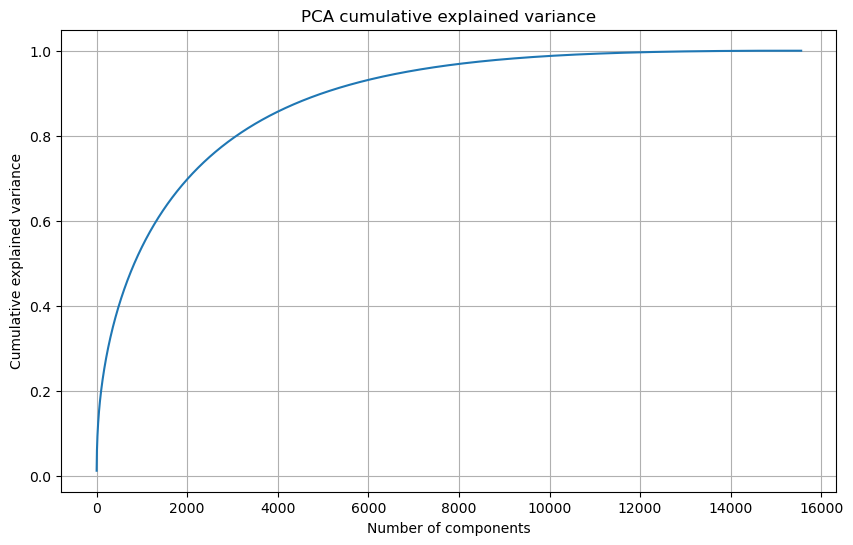

In [43]:
# # generate plot where on x axis we have number of components and on y axis cumulative variance
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance)
# plt.grid(True)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('PCA cumulative explained variance')

In [44]:
# n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
# n_components_70

2019

Mamy więc n_components = 2019.

In [59]:
# from sklearn.decomposition import IncrementalPCA
# # Create Incremental PCA object
# ipca = IncrementalPCA(n_components=2019)

# # Fit the data in batches
# batch_size = 2700
# for batch in range(0, len(df), batch_size):
#     X_batch = df[batch:batch+batch_size]
#     ipca.partial_fit(X_batch)

# # Transform the data in batches
# X_vgg16_pca = []
# for batch in range(0, len(df), batch_size):
#     X_batch = df[batch:batch+batch_size]
#     X_vgg16_pca_b = ipca.transform(X_batch)
#     X_vgg16_pca.append(X_vgg16_pca_b)

# # Concatenate the transformed batches
# X_vgg16_pca = np.vstack(X_vgg16_pca)
# df = pd.DataFrame(X_vgg16_pca)
# df.to_csv('X_vgg16_pca.csv')


In [58]:
# df.shape

(15557, 2019)

Ok, zgadza się.

---
## Modele
Rozważamy modele:
- (2)
- (3)
- (4) hierarchiczna klasteryzacja
- (5)
- (6) BIRCH
- (7) K-means na cechach z VGG16
#### Wczytanie danych

In [4]:
X_pca = pd.read_csv('X_pca.csv')
X_rot_pca = pd.read_csv('X_rot_pca.csv')
X_vgg16_pca = pd.read_csv('X_vgg16_pca.csv')

### Funkcje

In [20]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def calculate_dunn_index(X, labels):
    unique_cluster_labels = np.unique(labels)
    num_clusters = len(unique_cluster_labels)

    if num_clusters < 2:
        return float('inf')  # Dunn index is not defined for less than 2 clusters

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_cluster_labels:
        cluster_i = X[labels == i]
        if len(cluster_i) > 1:
            intra_cluster_distances.append(np.max(pairwise_distances(cluster_i)))

        for j in unique_cluster_labels:
            if i < j:
                cluster_j = X[labels == j]
                if len(cluster_j) > 0:
                    inter_cluster_distances.append(np.min(pairwise_distances(cluster_i, cluster_j)))

    if not inter_cluster_distances or not intra_cluster_distances:
        return float('inf')
    
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores


### 4. Klasteryzacja hierarchiczna
### 4.1. Dendogram

Przeanalizujmy dendogramy dla klasteryzacji hierarchicznej, wykorzystując metodę łączenia *ward*. Dla *average* był szalenie nieczytelny.

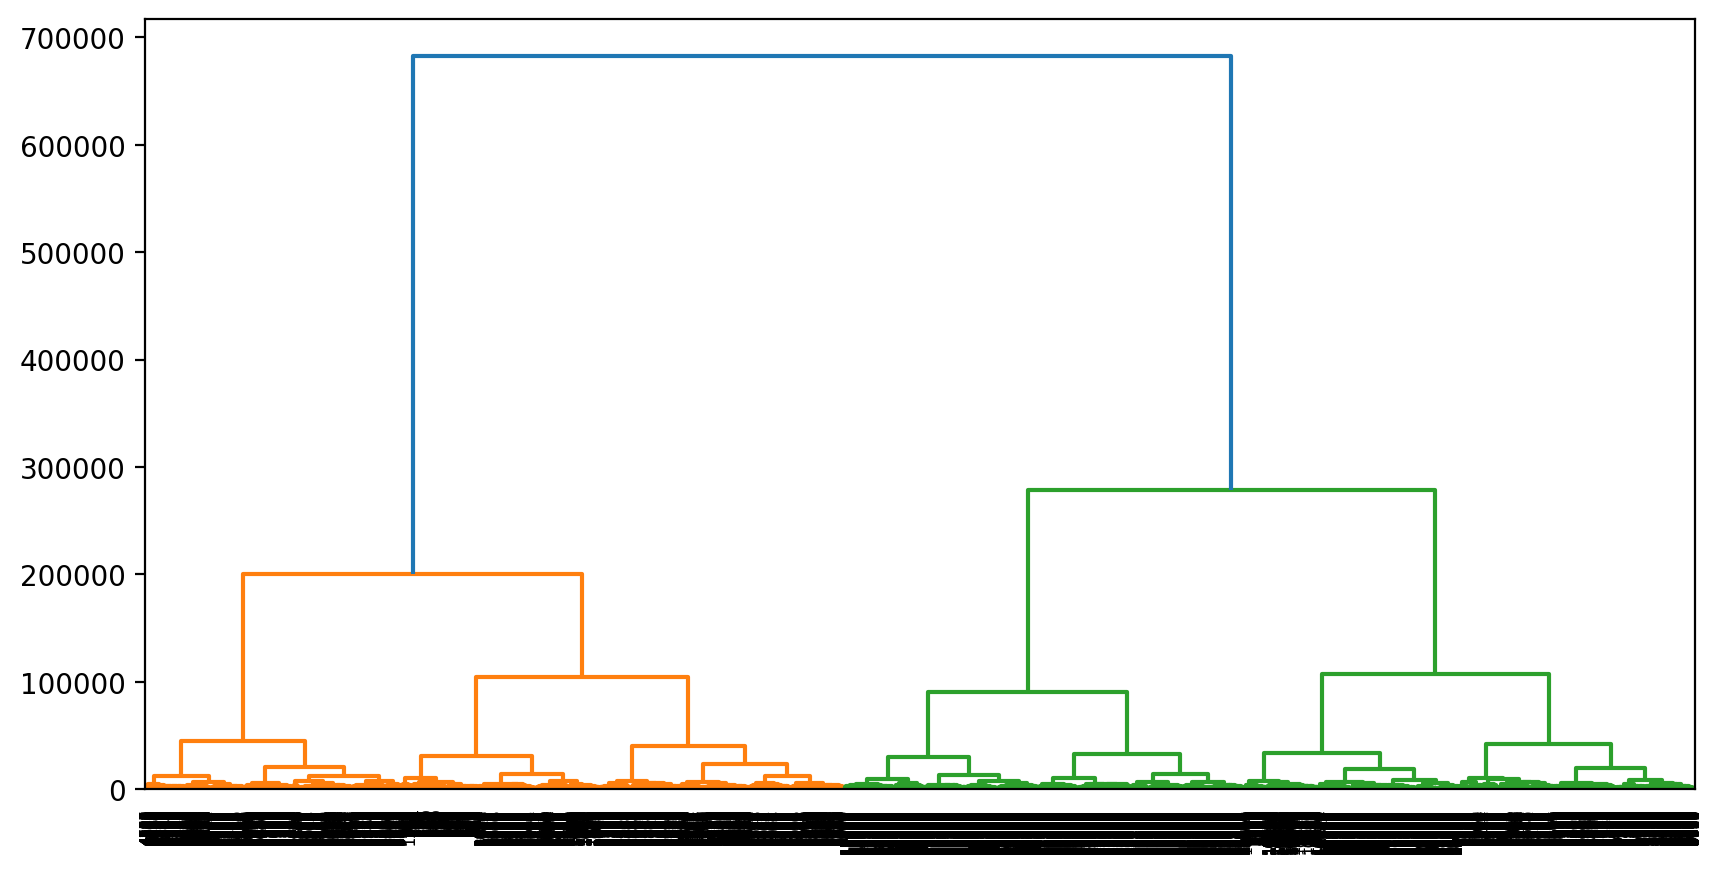

In [85]:
Z = hierarchy.linkage(X_vgg16_pca, method='ward')
plt.figure(figsize=(10,5), dpi=200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

Widać teraz, że dobrym kandydatem na *distance_threshold* jest ok. 90000, bowiem od tej wartości zmiany zaczynają zachodzić znacznie szybciej niż dla wyższych oraz liczba klastrów (7) jest akceptowalna i **może dobrze spełniać nasz cel biznesowy**.


Inaczej patrząc, od *liczby klastrów* = 7 przedziały możliwych wartości odległości między punktami są dużo mniejsze.


### 4.2. Analiza metryk
Przeanalizujemy model aglomeracyjnej klasteryzacji o *liczbie klastrów* = 5. Rozważymy różne metryki *linkage*.

In [95]:
metrices = {
            'silhouette': silhouette_score,
            'davies - bouldin' : davies_bouldin_score,
            'calinski - harabasz' : calinski_harabasz_score,
            'dunn' : calculate_dunn_index
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
         }

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        print(f"Processing model: {model_key}, metric: {metric_key}")  # Debug print
        score =  count_clustering_scores(X=X_vgg16_pca, cluster_num=7, model=models[model_key], score_fun=metrices[metric_key])
        df.loc[model_key, metric_key] = score
df

Processing model: Agglomerative ward linkage, metric: silhouette


### 4.3. Wybór modelu

W świetle powyższych czterech metryk, aż 3 osiągają najlepszy wynik dla **linkage = single**. Jest jednak niejedno **ALE**:
- model aglomerative z linkage = single tworzy 5 klastrów, w tym cztery z nich są 0 lub 1-elementowe,
- podobnie model aglomerative z linkage = average.  
Zatem spośród pozostałych dwóch, w każdej metryce lepiej wypada model aglomerative z **linkage = ward**.

In [47]:
model_hierarchy = AgglomerativeClustering(n_clusters=20, linkage='ward')

### 4.4. Weryfikacja klastrów

In [48]:
# add 'cluster column to the dataframe
X_pca_predicted = X_pca.copy()
X_pca_predicted['cluster'] = model_hierarchy.fit_predict(X_pca)

In [49]:
# number of samples in each cluster
cluster_sizes = X_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

cluster
5     1909
2     1848
3     1230
4      937
10     907
9      882
8      845
1      824
12     693
15     676
0      666
7      659
6      638
16     538
11     451
13     437
17     431
18     395
14     356
19     235
Name: count, dtype: int64


Zatem liczba obrazów w klastrach przedstawia się następująco:    
0    5296  
3    4381  
2    2703  
1    2074  
4    1103

### 4.5. Przegląd obrazów w klastrach.

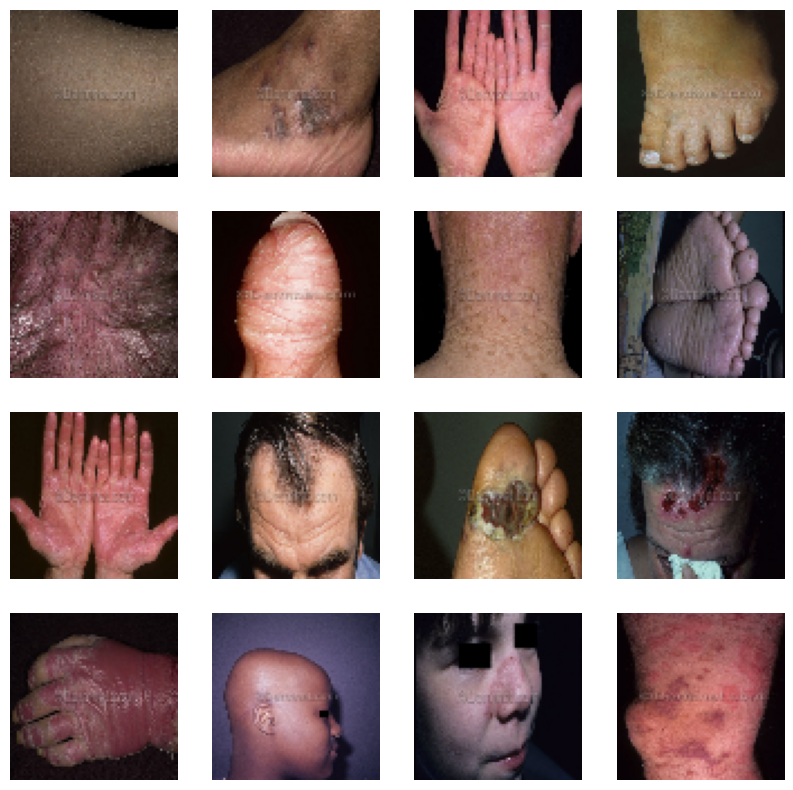

In [51]:
clusters = X_pca_predicted['cluster'].unique().tolist()
selected_images = {cluster : [] for c in clusters}
random.seed(2137)
for cluster in clusters:
    cluster_indices = X_pca_predicted[X_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), 16)
    selected_images[cluster] = X.iloc[selected_indices]['image'].values
# visualize 
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[7][j])
    axes[j//4, j%4].axis('off')

### 4.6. Wnioski
- obrazy w klastrach nie są do siebie podobne.

### 6. BIRCH
Decydujemy się na wypróbowanie modelu Birch, bowiem "Balanced Iterative Reducing and Clustering using Hierarchies also know as BIRCH is a clustering algorithm using which we can cluster large datasets by first producing a brief summary about the dataset that preserves information as much as possible.".
### 6.1. Model
_Uwaga:_ Model Birch działał niezadowalająco na ramkach danych `X_pca` oraz `X_rot_pca`. Najlepsze wyniki, zaprezentowane poniżej, są osiągnięte na zbiorze `X_vgg16_pca`.    

Z dendogramu i metody łokcia (patrz: 7.1.) widać, że **k=7** jest dobrym kandyydatem na liczbę klastrów.

In [87]:
model = Birch(threshold=1.5, n_clusters=7, branching_factor=50)
model.fit(X_vgg16_pca)
X_vgg16_pca_predicted = X_vgg16_pca.copy()
X_vgg16_pca_predicted['cluster'] = model.predict(X_vgg16_pca)

In [88]:
# number of samples in each cluster
cluster_sizes = X_vgg16_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

cluster
0    3320
1    3117
3    2047
2    1984
4    1915
5    1760
6    1414
Name: count, dtype: int64


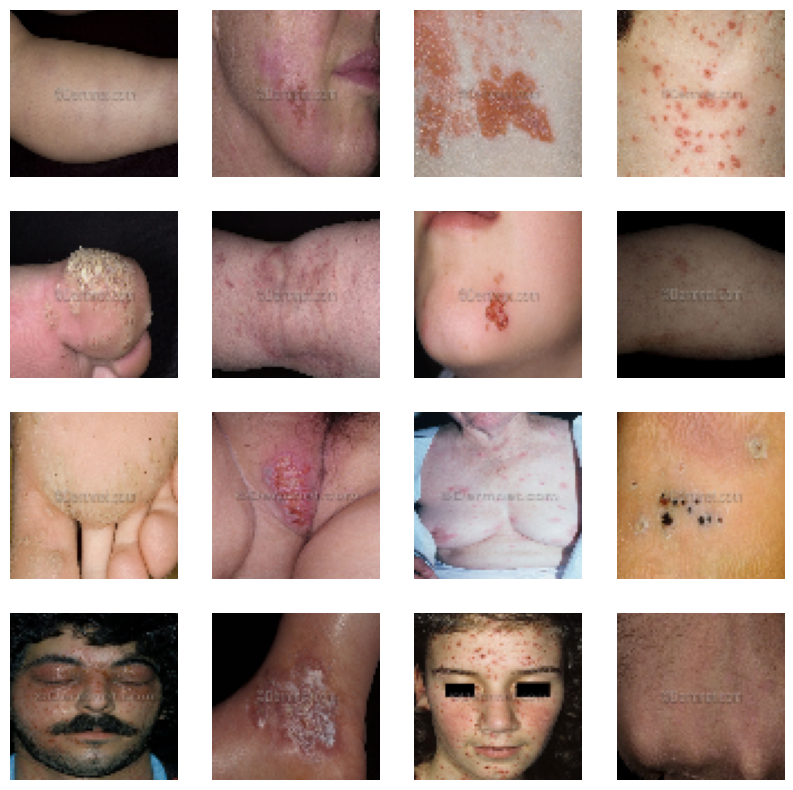

In [94]:
clusters = X_vgg16_pca_predicted['cluster'].unique().tolist()
selected_images = {c : [] for c in clusters}
for cluster in clusters:
    cluster_indices = X_vgg16_pca_predicted[X_vgg16_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), min(16, len(cluster_indices)))
    selected_images[cluster] = X.iloc[selected_indices]['image'].values

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[6][j])
    axes[j//4, j%4].axis('off')

### 6.2. Wnioski
- Obrazy są wymieszane :(

### 7. VGG16 features + K-means
Wykorzystamy model VGG16 do wyciągnięcia cech z niezmodyfikowanych obrazów, a następnie zastosujemy algorytm K-Means.

In [7]:
X_vgg16_pca = pd.read_csv('X_vgg16_pca.csv')

### 7.1. Metoda łokcia

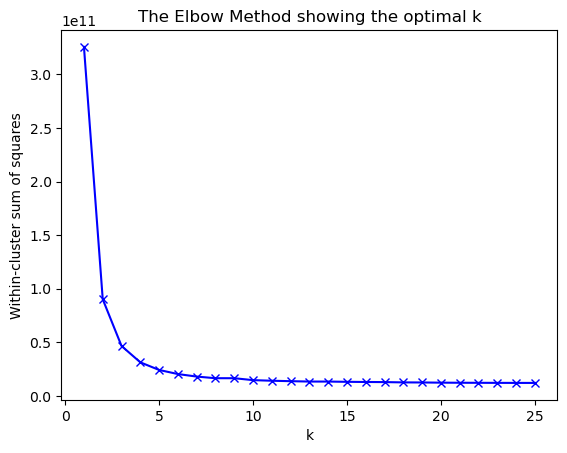

In [11]:
wcss_vec = count_wcss_scores(X_vgg16_pca, 25)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Z tego wykresu wynika, że dobrymi kandydatami na liczbę klastrów jest 3 lub 5. Przyjrzyjmy się, jak zmienia się współczynnik WCSS dla k >= 4.

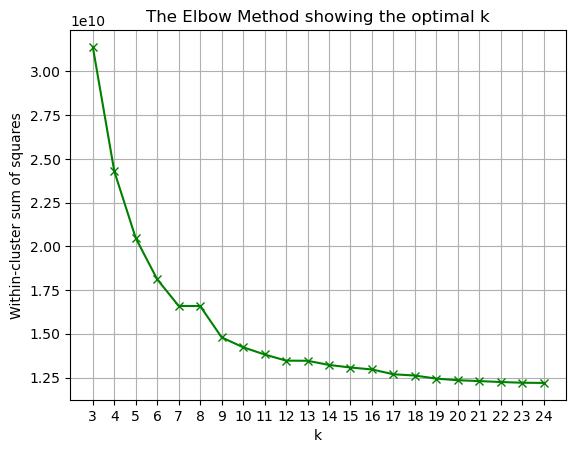

In [33]:
plt.plot(list(range(3, 25)), wcss_vec[3:25], 'gx-')
plt.xticks(list(range(3, 25)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Nowymi kandydatami na liczbę klastrów są więc **7, 12 i 17**.

### 7.2. Współczynnik silhouette

In [21]:
silhouette_scores = count_clustering_scores(X_vgg16_pca, range(2, 25), KMeans, silhouette_score)

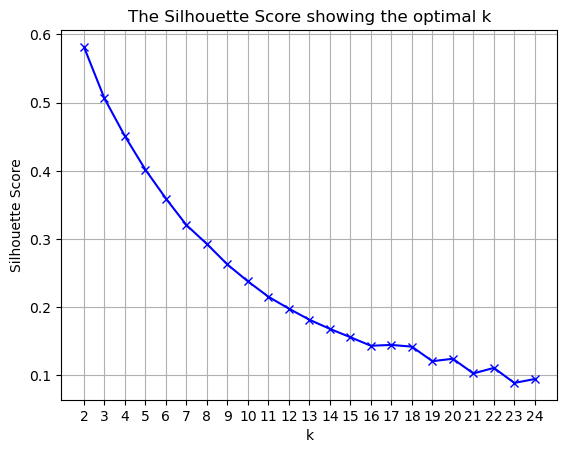

In [24]:
plt.plot(list(range(2, 25)), silhouette_scores, 'bx-')
plt.xticks(list(range(2, 25)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Score showing the optimal k')
plt.show()

Wartości współczynnika sugerują, że im mniejsza liczba klastrów, tym lepiej, a największą *dobrą* wartością k jest 17 (od tego momentu SiScore szybciej maleje).

### 7.3. Indeks Dunna

In [27]:
dunn_indexes = []
for k in range(2, 25):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X_vgg16_pca)
    dunn = calculate_dunn_index(X_vgg16_pca, labels)
    dunn_indexes.append(dunn)

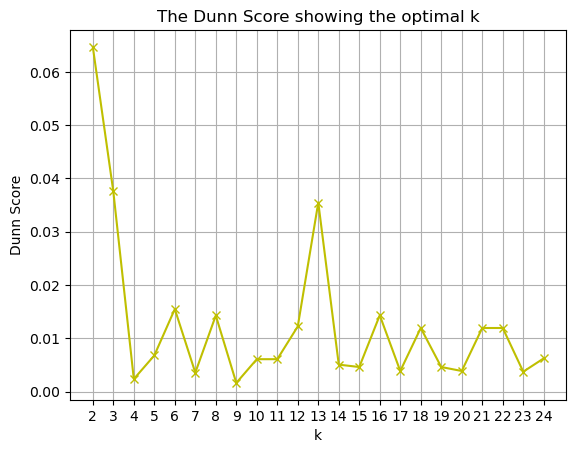

In [29]:
plt.plot(list(range(2, 25)), dunn_indexes, 'yx-')
plt.xticks(list(range(2, 25)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Dunn Score')
plt.title('The Dunn Score showing the optimal k')
plt.show()

### 7.4. Index Daviesa-Bouldina

In [25]:
daviess_bouldin_scores = count_clustering_scores(X_vgg16_pca, range(2, 25), KMeans, davies_bouldin_score)

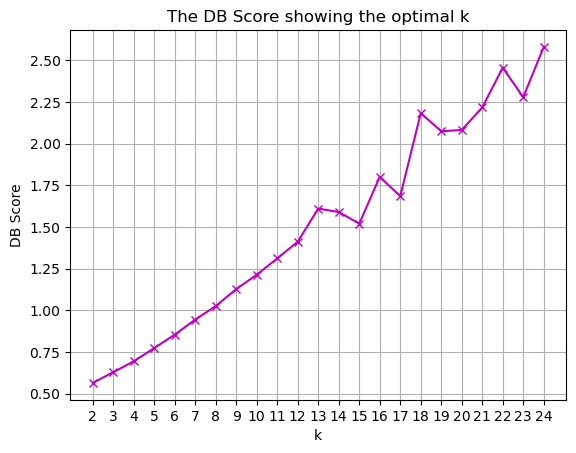

In [31]:
plt.plot(list(range(2, 25)), daviess_bouldin_scores, 'mx-')
plt.xticks(list(range(2, 25)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('DB Score')
plt.title('The DB Score showing the optimal k')
plt.show()

Im mniej klastrów, tym lepiej. Największe akceptowalne wartości to 15 i 17. Wykluczone powinny zostać 13, 14, 16 i >=18.

### 7.5. Indeks Calińskiego-Harabasza

In [30]:
ch_scores = count_clustering_scores(X_vgg16_pca, range(2, 25), KMeans, calinski_harabasz_score)

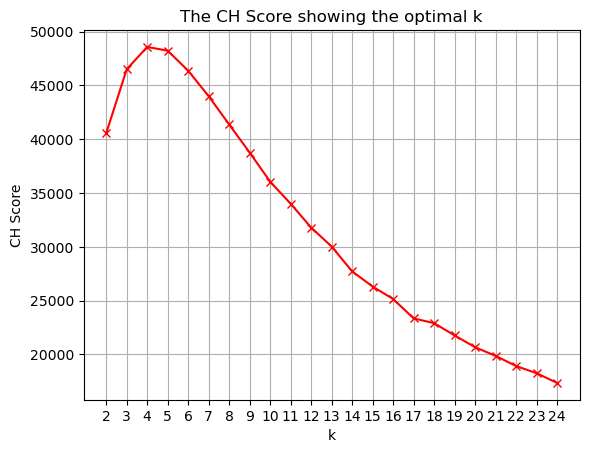

In [32]:
plt.plot(list(range(2, 25)), ch_scores, 'rx-')
plt.xticks(list(range(2, 25)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('CH Score')
plt.title('The CH Score showing the optimal k')
plt.show()

Najlepiej podzielić na 5 klastrów.

### 7.6. Weryfikacja 
#### 7.6.1. k = 5

In [42]:
model = KMeans(n_clusters=5)
model.fit(X_vgg16_pca)
X_vgg16_pca_predicted = X_vgg16_pca.copy()
X_vgg16_pca_predicted['cluster'] = model.predict(X_vgg16_pca)

In [44]:
cluster_sizes = X_vgg16_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

cluster
1    3121
4    3116
3    3112
2    3110
0    3098
Name: count, dtype: int64


Klastry mają podobną liczbę elementów.

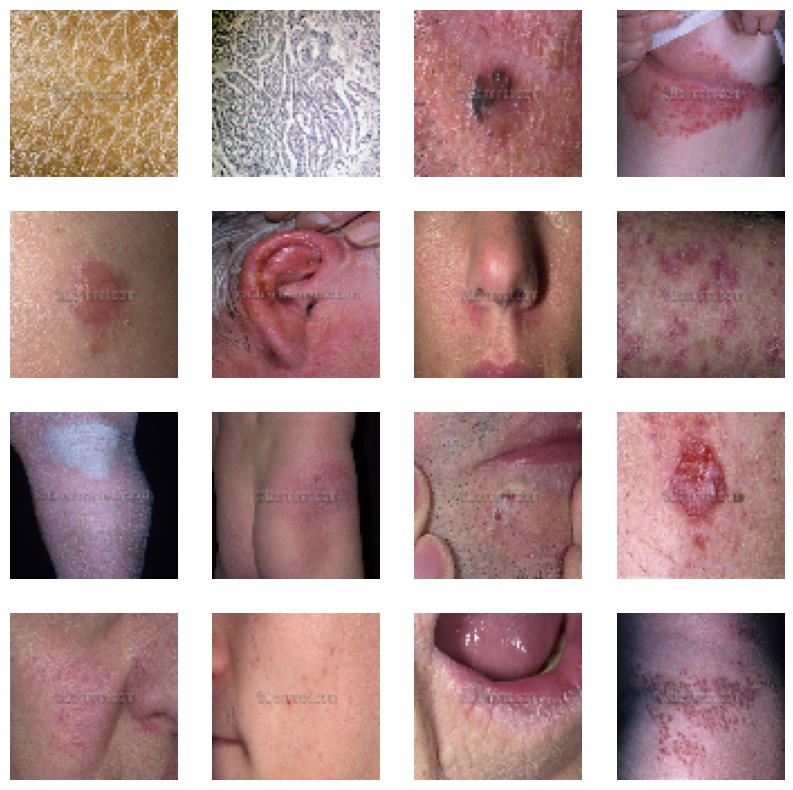

In [51]:
clusters = X_vgg16_pca_predicted['cluster'].unique().tolist()
selected_images = {c : [] for c in clusters}
for cluster in clusters:
    cluster_indices = X_vgg16_pca_predicted[X_vgg16_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), 16)
    selected_images[cluster] = X.iloc[selected_indices]['image'].values
# visualize 
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[4][j])
    axes[j//4, j%4].axis('off')

**Całkiem dobre klastrowanie - można nadać nazwy klastrom z dokładnością do 50%**. Np. klaster 4: na głowie (twarz, uszy, szyja), klaster 0: 'pieprzyki'.

#### 7.6.2. k = 7

In [52]:
model = KMeans(n_clusters=7)
model.fit(X_vgg16_pca)
X_vgg16_pca_predicted = X_vgg16_pca.copy()
X_vgg16_pca_predicted['cluster'] = model.predict(X_vgg16_pca)
cluster_sizes = X_vgg16_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

clusters = X_vgg16_pca_predicted['cluster'].unique().tolist()
selected_images = {c : [] for c in clusters}
for cluster in clusters:
    cluster_indices = X_vgg16_pca_predicted[X_vgg16_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), 16)
    selected_images[cluster] = X.iloc[selected_indices]['image'].values

cluster
1    2290
3    2282
0    2255
6    2223
2    2195
5    2156
4    2156
Name: count, dtype: int64


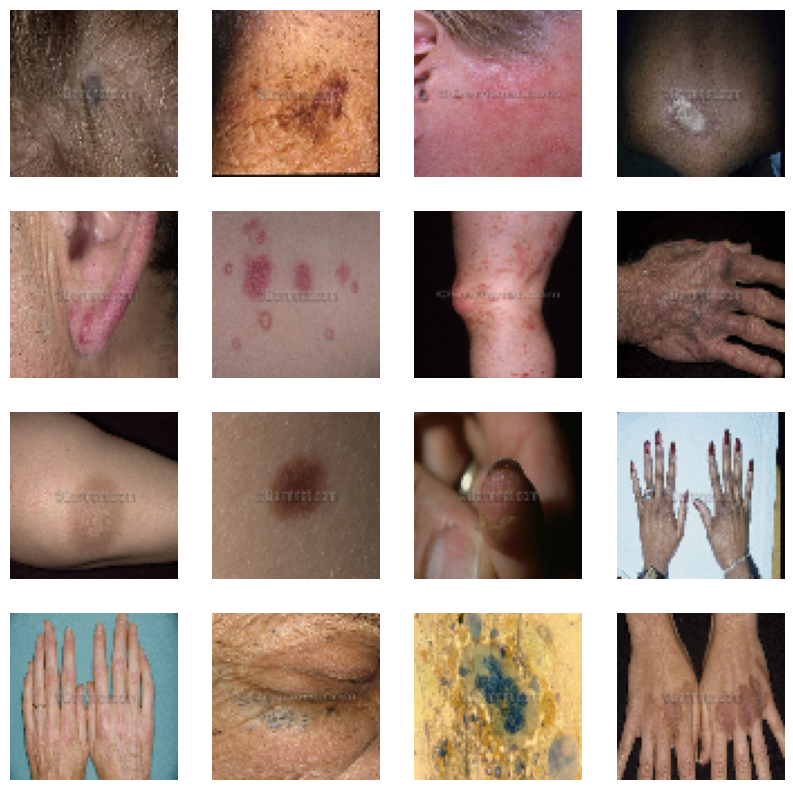

In [56]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[0][j])
    axes[j//4, j%4].axis('off')

Tutaj trudniej nazwać klastry.
#### 7.6.3. k = 12

In [58]:
model = KMeans(n_clusters=12)
model.fit(X_vgg16_pca)
X_vgg16_pca_predicted = X_vgg16_pca.copy()
X_vgg16_pca_predicted['cluster'] = model.predict(X_vgg16_pca)
cluster_sizes = X_vgg16_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

clusters = X_vgg16_pca_predicted['cluster'].unique().tolist()
selected_images = {c : [] for c in clusters}
for cluster in clusters:
    cluster_indices = X_vgg16_pca_predicted[X_vgg16_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), 16)
    selected_images[cluster] = X.iloc[selected_indices]['image'].values

cluster
6     1449
2     1446
7     1427
4     1425
0     1418
5     1343
11    1264
8     1251
3     1244
10    1185
1     1095
9     1010
Name: count, dtype: int64


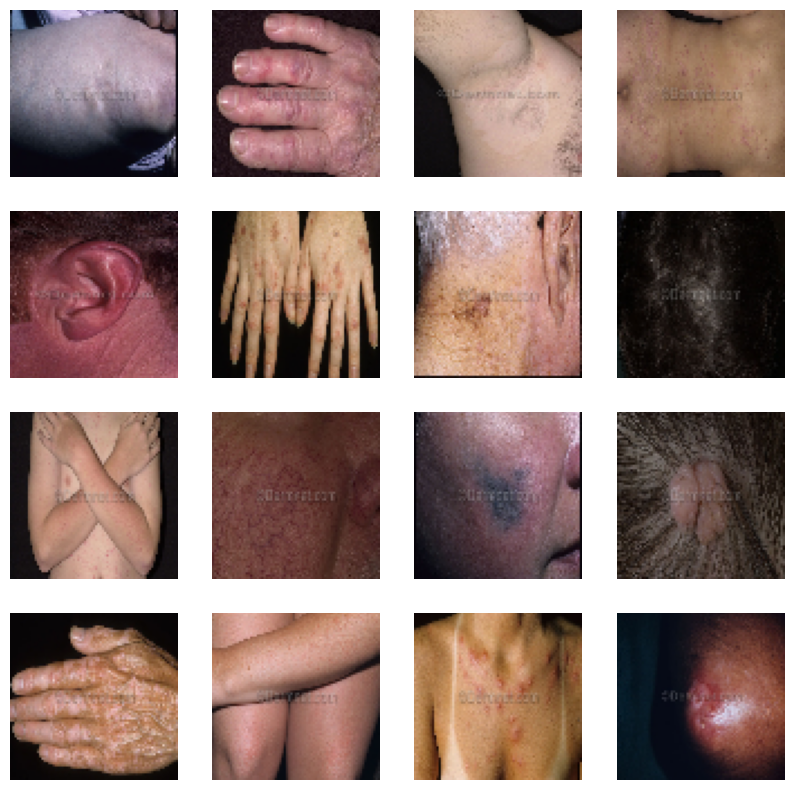

In [67]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[11][j])
    axes[j//4, j%4].axis('off')

**Dobre klastrowanie.** Np. w klastrze 9. mamy usta, 6. - brązowe pieprzyki, 10. i 11. - palce, natomiast jest kilka nieścisłości - klaster 4. zawiera losowe zdjęcia.

#### 7.6.4. k = 17

In [70]:
model = KMeans(n_clusters=17)
model.fit(X_vgg16_pca)
X_vgg16_pca_predicted = X_vgg16_pca.copy()
X_vgg16_pca_predicted['cluster'] = model.predict(X_vgg16_pca)
cluster_sizes = X_vgg16_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

clusters = X_vgg16_pca_predicted['cluster'].unique().tolist()
selected_images = {c : [] for c in clusters}
for cluster in clusters:
    cluster_indices = X_vgg16_pca_predicted[X_vgg16_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), min(16, len(cluster_indices)))
    selected_images[cluster] = X.iloc[selected_indices]['image'].values

cluster
9     1064
6     1040
0     1023
8     1010
10    1005
1      990
12     988
15     984
3      980
4      973
16     949
14     942
13     920
11     908
7      892
5      888
2        1
Name: count, dtype: int64


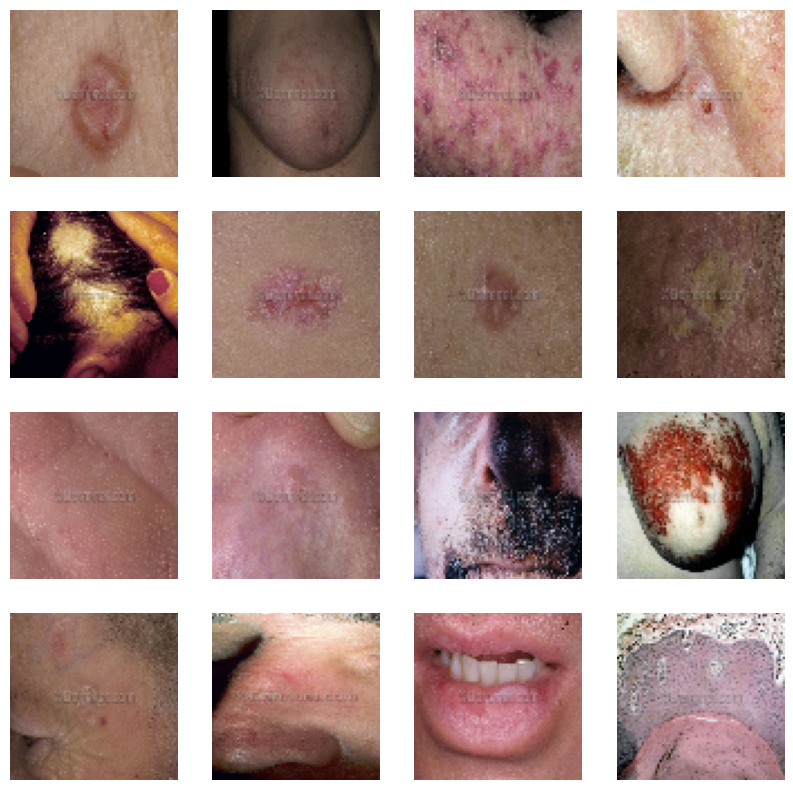

In [76]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[0][j])
    axes[j//4, j%4].axis('off')

Choć wartości badanych współczynników sugerowały, że 17 da nam dobre klastrowanie, to w rzeczywistości obrazy w grupach nie mają dużo cech wspólnych.